In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker

plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['figure.dpi'] = 300

RESULTS_DIR = '/global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/results'
FIGURE_DIR = '/global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics'
FIGURE_WIDTH = 5.4

In [4]:
# names + color scheme
METRIC_PRETTY_NAMES = {
    'total_revenue': 'Revenue ($M)',
    'total_welfare': 'Welfare ($M)',
    'auction_lengths_no_prefix': 'Length',
    'num_lotteries': 'Number of Lotteries',
    'unsold_licenses': 'Unsold Licenses',
}
POLICY_PRETTY_NAMES_AND_COLORS = {
    'DROP_BY_PLAYER': ('Drop by Player', 'tab:blue'),
    'DROP_BY_LICENSE': ('Drop by License', 'tab:orange'),
}

# positioning and limits
POLICY_Y_OFFSETS = {
    'DROP_BY_PLAYER': -0.13,
    'DROP_BY_LICENSE': 0.13,
}
AXIS_LIMITS = {
    'auction_lengths_no_prefix': (0.9, 2.1),
    'num_lotteries': (-0.1, 1.1),
    'unsold_licenses': (-0.1, 1.1),
    'total_revenue': (42.5, 44.5),
    'total_welfare': (62.5, 87.5),
}

AXIS_LIMITS.update({f'straightforward_{k}': v for k,v in AXIS_LIMITS.items()})
METRIC_PRETTY_NAMES.update({f'straightforward_{k}': v for k,v in METRIC_PRETTY_NAMES.items()})

EPSILON = 1e-6


In [13]:
def my_fmt(x, pos):
    if x == 0:
        return '0'
    return f'{x:.1f}'

def plot_metrics_by_game(df, metrics=None, fname='plot.png', straightforward=False, figsize=None, axis_limits='auto', include_legend=True):
    if metrics is None:
        metrics = ['auction_lengths_no_prefix', 'num_lotteries', 'unsold_licenses', 'total_revenue', 'total_welfare']
        
    if straightforward:
        metrics = [f'straightforward_{m}' for m in metrics]

    if figsize is None:
        figsize = (FIGURE_WIDTH, 1.8)


    
    n_types_list = sorted(df.n_types.unique())
    fig, ax_list = plt.subplots(len(n_types_list), len(metrics), figsize=figsize, sharey=True, squeeze=False)
    for i, n_types in enumerate(n_types_list):
        df_i = df[df.n_types == n_types]
        game_names = np.sort(df_i.base_game_name.unique()).tolist()

        df_plt = df_i[['base_game_name', 'tiebreaking_policy']].drop_duplicates().reset_index(drop=True)
        df_plt['plt_y'] = df_plt.apply(lambda x: 1 + game_names.index(x.base_game_name) + POLICY_Y_OFFSETS[x.tiebreaking_policy], axis=1)
        df_plt['plt_color'] = df_plt.tiebreaking_policy.apply(lambda x: POLICY_PRETTY_NAMES_AND_COLORS[x][1])
        df_i = df.merge(df_plt, on=['base_game_name', 'tiebreaking_policy'])
    
        agg_dict = {**{f'min_{metric}': (metric, np.min) for metric in metrics}, **{f'max_{metric}': (metric, np.max) for metric in metrics}}
        df_ranges_i = df_i.groupby(['base_game_name', 'tiebreaking_policy'], as_index=False)[metrics].agg(**agg_dict).reset_index().merge(df_plt, on=['base_game_name', 'tiebreaking_policy'])
        
        for j, metric in enumerate(metrics):
            plt.sca(ax_list[i, j])
            plt.scatter(x=df_i[metric], y=df_i.plt_y, c=df_i.plt_color, s=5, zorder=10, clip_on=False)
            for _, row in df_ranges_i.iterrows():
                plt.plot([row[f'min_{metric}'], row[f'max_{metric}']], [row.plt_y, row.plt_y], linewidth=1, color=row.plt_color, zorder=10)
            
            if axis_limits == 'auto':
                min_metric, max_metric = min(df_ranges_i[f'min_{metric}']), max(df_ranges_i[f'max_{metric}'])
                dx = max((0.05 * (max_metric - min_metric)), 0.1)
                plt.xlim(max(0, min(df[metric]) - dx), max(df[metric]) + dx)
            else:
                xmin, xmax = axis_limits[metric]
                plt.xlim(xmin, xmax)
                if min(df[metric]) < xmin - EPSILON:
                    print(f'WARNING: minimum {metric} of {min(df[metric])} smaller than axis limit of {xmin}')
                if max(df[metric]) > xmax + EPSILON:
                    print(f'WARNING: maximum {metric} of {max(df[metric])} larger than axis limit of {xmax}')

            if i == len(n_types_list) - 1:
                plt.xlabel(METRIC_PRETTY_NAMES[metric])
                plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(my_fmt))
            else:
                plt.gca().set_xticklabels([])
            if j == 0:
                plt.ylabel('1 Type' if n_types == 1 else f'{n_types} Types')
                plt.yticks(np.arange(1, len(game_names) + 1))
                plt.ylim(len(game_names) + 0.5, 0.5)


    plt.tight_layout()
    if include_legend:
        fig.subplots_adjust(bottom=0.35 / len(n_types_list))
        custom_lines = [Line2D([0], [0], color=POLICY_PRETTY_NAMES_AND_COLORS[p][1], lw=2) for p in POLICY_PRETTY_NAMES_AND_COLORS]
        fig.legend(custom_lines, [POLICY_PRETTY_NAMES_AND_COLORS[p][0] for p in POLICY_PRETTY_NAMES_AND_COLORS], loc='lower center', bbox_to_anchor=(0.5,-0.05), ncol=2)

    path = os.path.join(FIGURE_DIR, fname)
    os.makedirs(os.path.dirname(path), exist_ok=True) # make directory if it doesn't exist
    plt.savefig(path, bbox_inches='tight', pad_inches=0.05)
    print(f'Saved figure to {path}')

# Slides

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/slides/7type_marl.png


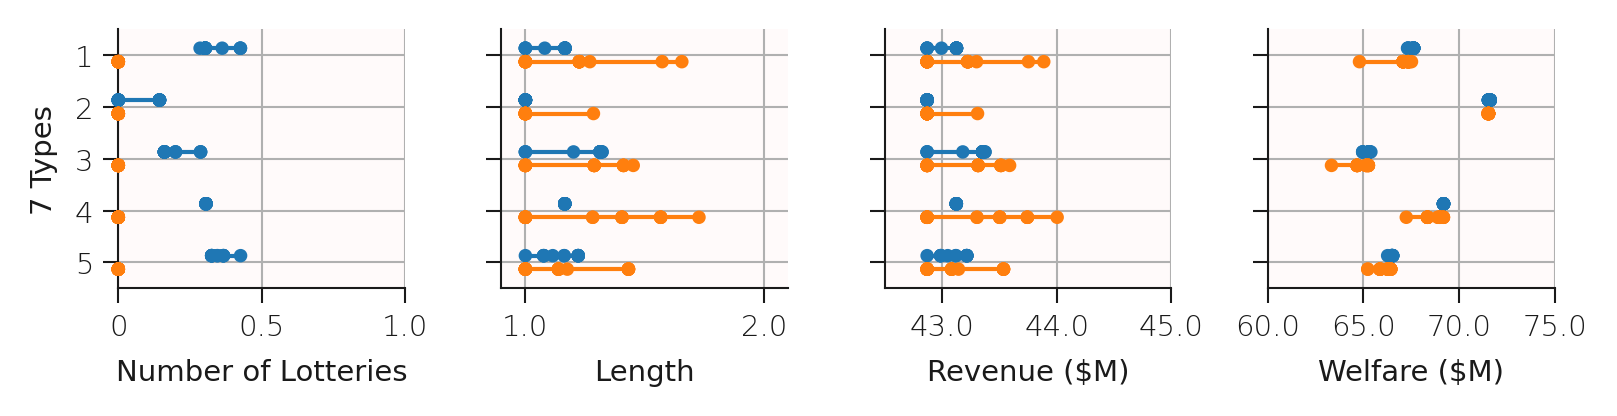

In [14]:
metrics = [
    'num_lotteries', 
    'auction_lengths_no_prefix', 
    # 'unsold_licenses', 
    'total_revenue', 
    'total_welfare'
]
axis_limits = {
    'auction_lengths_no_prefix': (0.9, 2.1),
    'num_lotteries': (0, 1),
    'unsold_licenses': (0, 1),
    'total_revenue': (42.5, 45.0),
    'total_welfare': (60.0, 75.0),
}
nash_conv_threshold = 0.1


df_cfr = pd.read_csv(f'{RESULTS_DIR}/feb10_2p_v1.csv').query('rho == 1')
df_cfr['auction_lengths_no_prefix'] = df_cfr.auction_lengths - 2
df_ppo = pd.read_csv(f'{RESULTS_DIR}/feb12_2p_ppo_v1.csv')
df_ppo['auction_lengths_no_prefix'] = df_ppo.auction_lengths - 2
df_combined = pd.concat([df_cfr, df_ppo])
df_7type = df_combined.query(f'n_types == 7 and nash_conv < {nash_conv_threshold}')


plot_metrics_by_game(df_7type, fname=f'slides/7type_marl.png', metrics=metrics, axis_limits=axis_limits, figsize=(FIGURE_WIDTH, 1.4), include_legend=False); plt.show()

plot_metrics_by_game(df_7type, fname=f'slides/7type_marl.png', metrics=metrics, axis_limits=axis_limits, figsize=(FIGURE_WIDTH, 1.4), include_legend=False); plt.show()

# 3-player games (for paper)

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v2/cfr.png


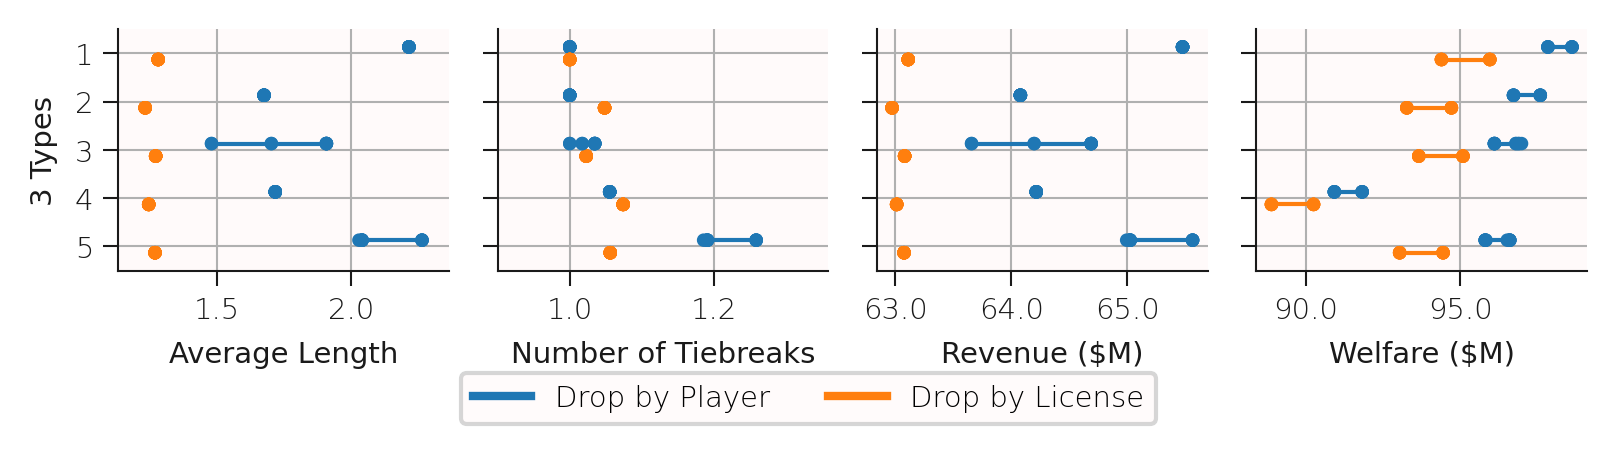

In [268]:
df_cfr = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_5supply_v2.csv')
df_cfr['auction_lengths_no_prefix'] = df_cfr.auction_lengths - 2
metrics = ['auction_lengths_no_prefix', 'num_lotteries', 'total_revenue', 'total_welfare']
plot_metrics_by_game(df_cfr, fname=f'feb8_3p_5supply_v2/cfr.png', metrics=metrics, figsize=(FIGURE_WIDTH, 1.4), axis_limits='auto'); plt.show()

# df_ppo = pd.read_csv(f'{RESULTS_DIR}/feb12_3p_ppo_v1.csv')
# df_ppo['auction_lengths_no_prefix'] = df_ppo.auction_lengths - 2
# metrics = ['auction_lengths_no_prefix', 'num_lotteries', 'total_revenue', 'total_welfare']
# plot_metrics_by_game(df_ppo, fname=f'feb8_3p_5supply_v2/ppo.png', metrics=metrics, figsize=(FIGURE_WIDTH, 1.4), axis_limits='auto'); plt.show()

In [273]:
(~df_cfr.nash_conv.isna()).sum()

46

In [282]:
df_cfr.query('~nash_conv.isnull()')[['base_game_name', 'rule', 'nash_conv', 'nash_conv_runtime']].sort_values('nash_conv').reset_index()

,index,base_game_name,rule,nash_conv,nash_conv_runtime
0,0,feb8_3p_5supply_3,tie_break,0.000000,3421.541336
1,58,feb8_3p_5supply_2,tie_break,0.000000,3479.789458
2,59,feb8_3p_5supply_2,tie_break,0.000000,3478.335157
3,60,feb8_3p_5supply_2,tie_break,0.000000,3234.399476
4,61,feb8_3p_5supply_2,tie_break,0.000000,3231.143699
5,72,feb8_3p_5supply_1,base,0.000000,3406.593693
6,73,feb8_3p_5supply_1,base,0.000000,2777.168987
7,74,feb8_3p_5supply_1,base,0.000000,2509.759812
8,75,feb8_3p_5supply_1,base,0.000000,2377.639198
9,77,feb8_3p_5supply_0,base,0.000000,2721.936540


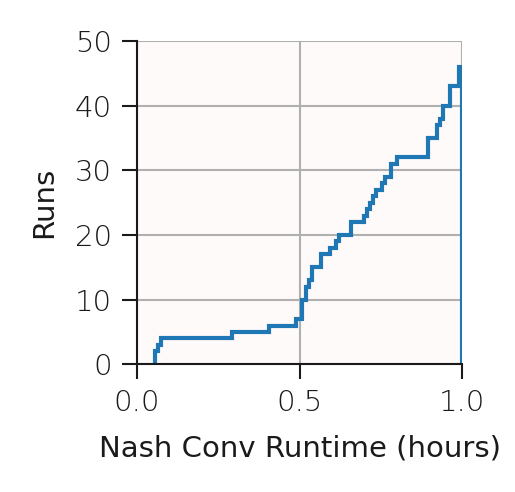

In [279]:
plt.figure(figsize=(1.4, 1.4))
plt.hist(df_cfr.query('~nash_conv.isnull()').nash_conv_runtime / 3600, cumulative=True, bins=100, histtype='step')
plt.xlabel('Nash Conv Runtime (hours)')
plt.ylabel('Runs')
plt.xlim(0, 1)
plt.savefig(f'{FIGURE_DIR}/feb8_3p_5supply_v2/cfr_nash_conv_runtime.png', bbox_inches='tight', pad_inches=0.05)
plt.show()

# feb10_2p_v1 (2 player games for paper)

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/cfr.png


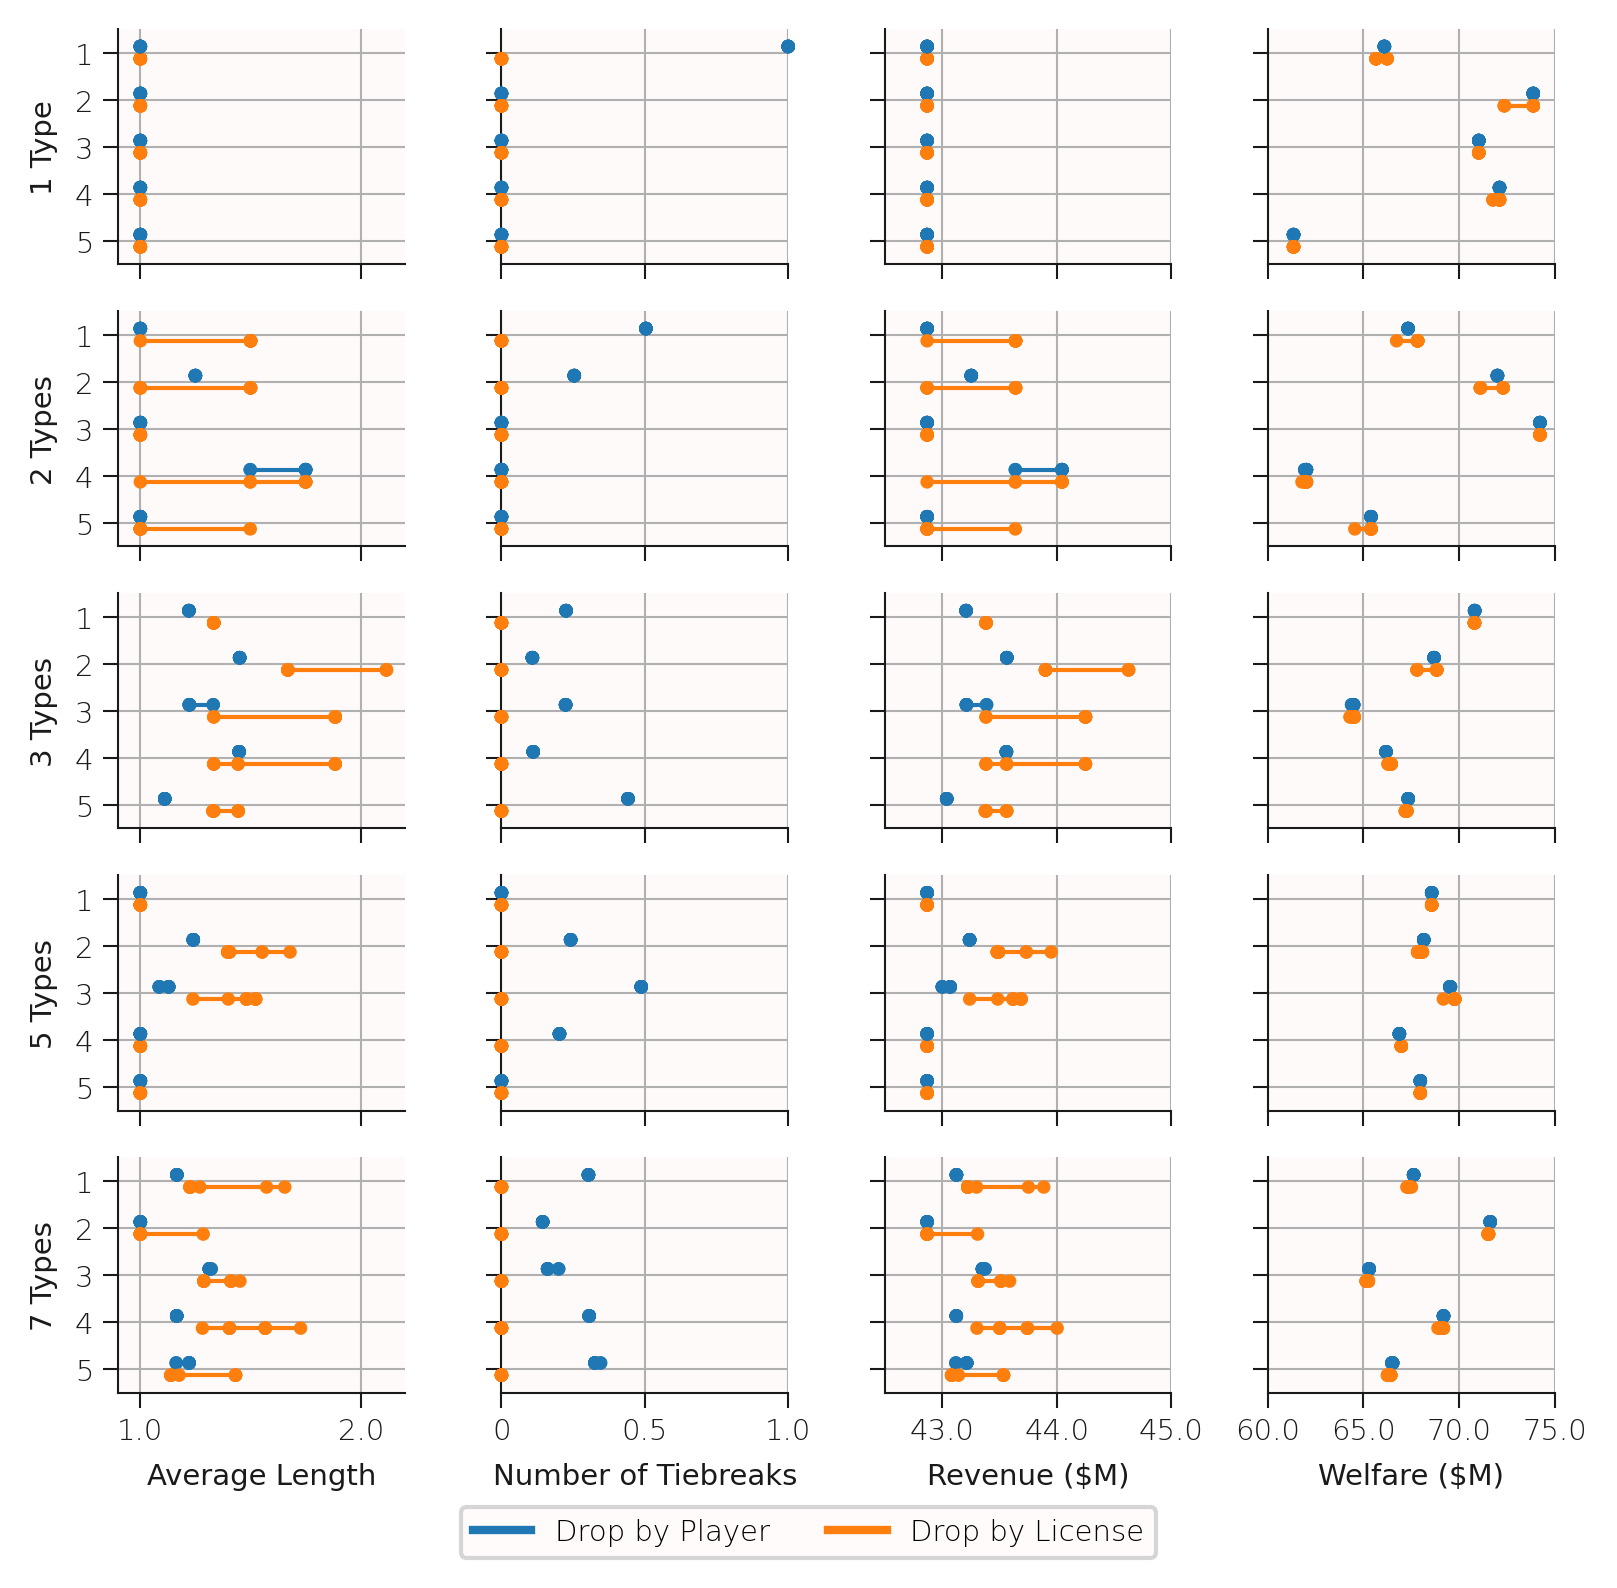

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/ppo.png


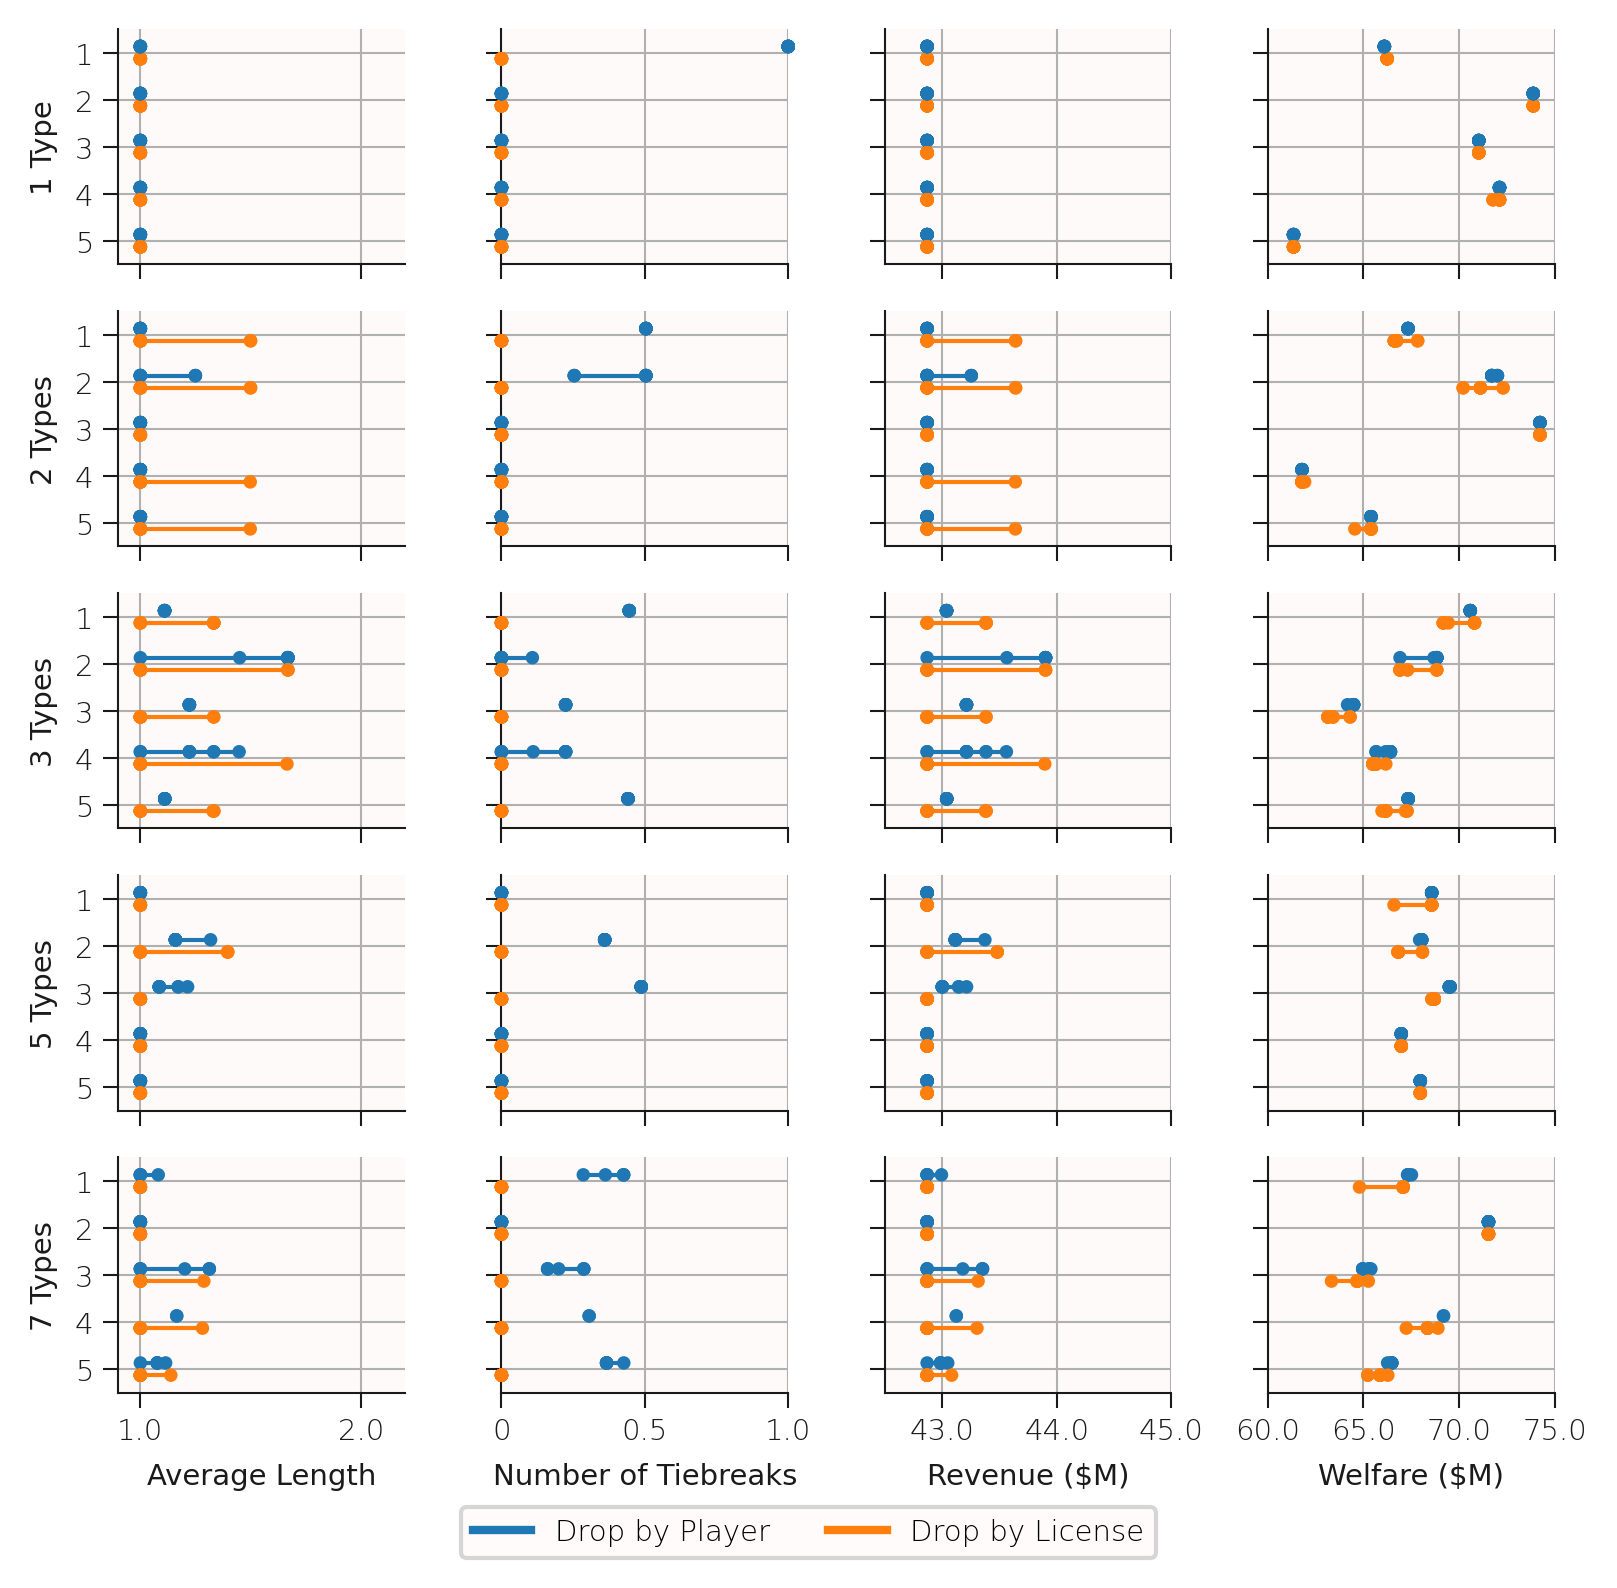

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/combined.png


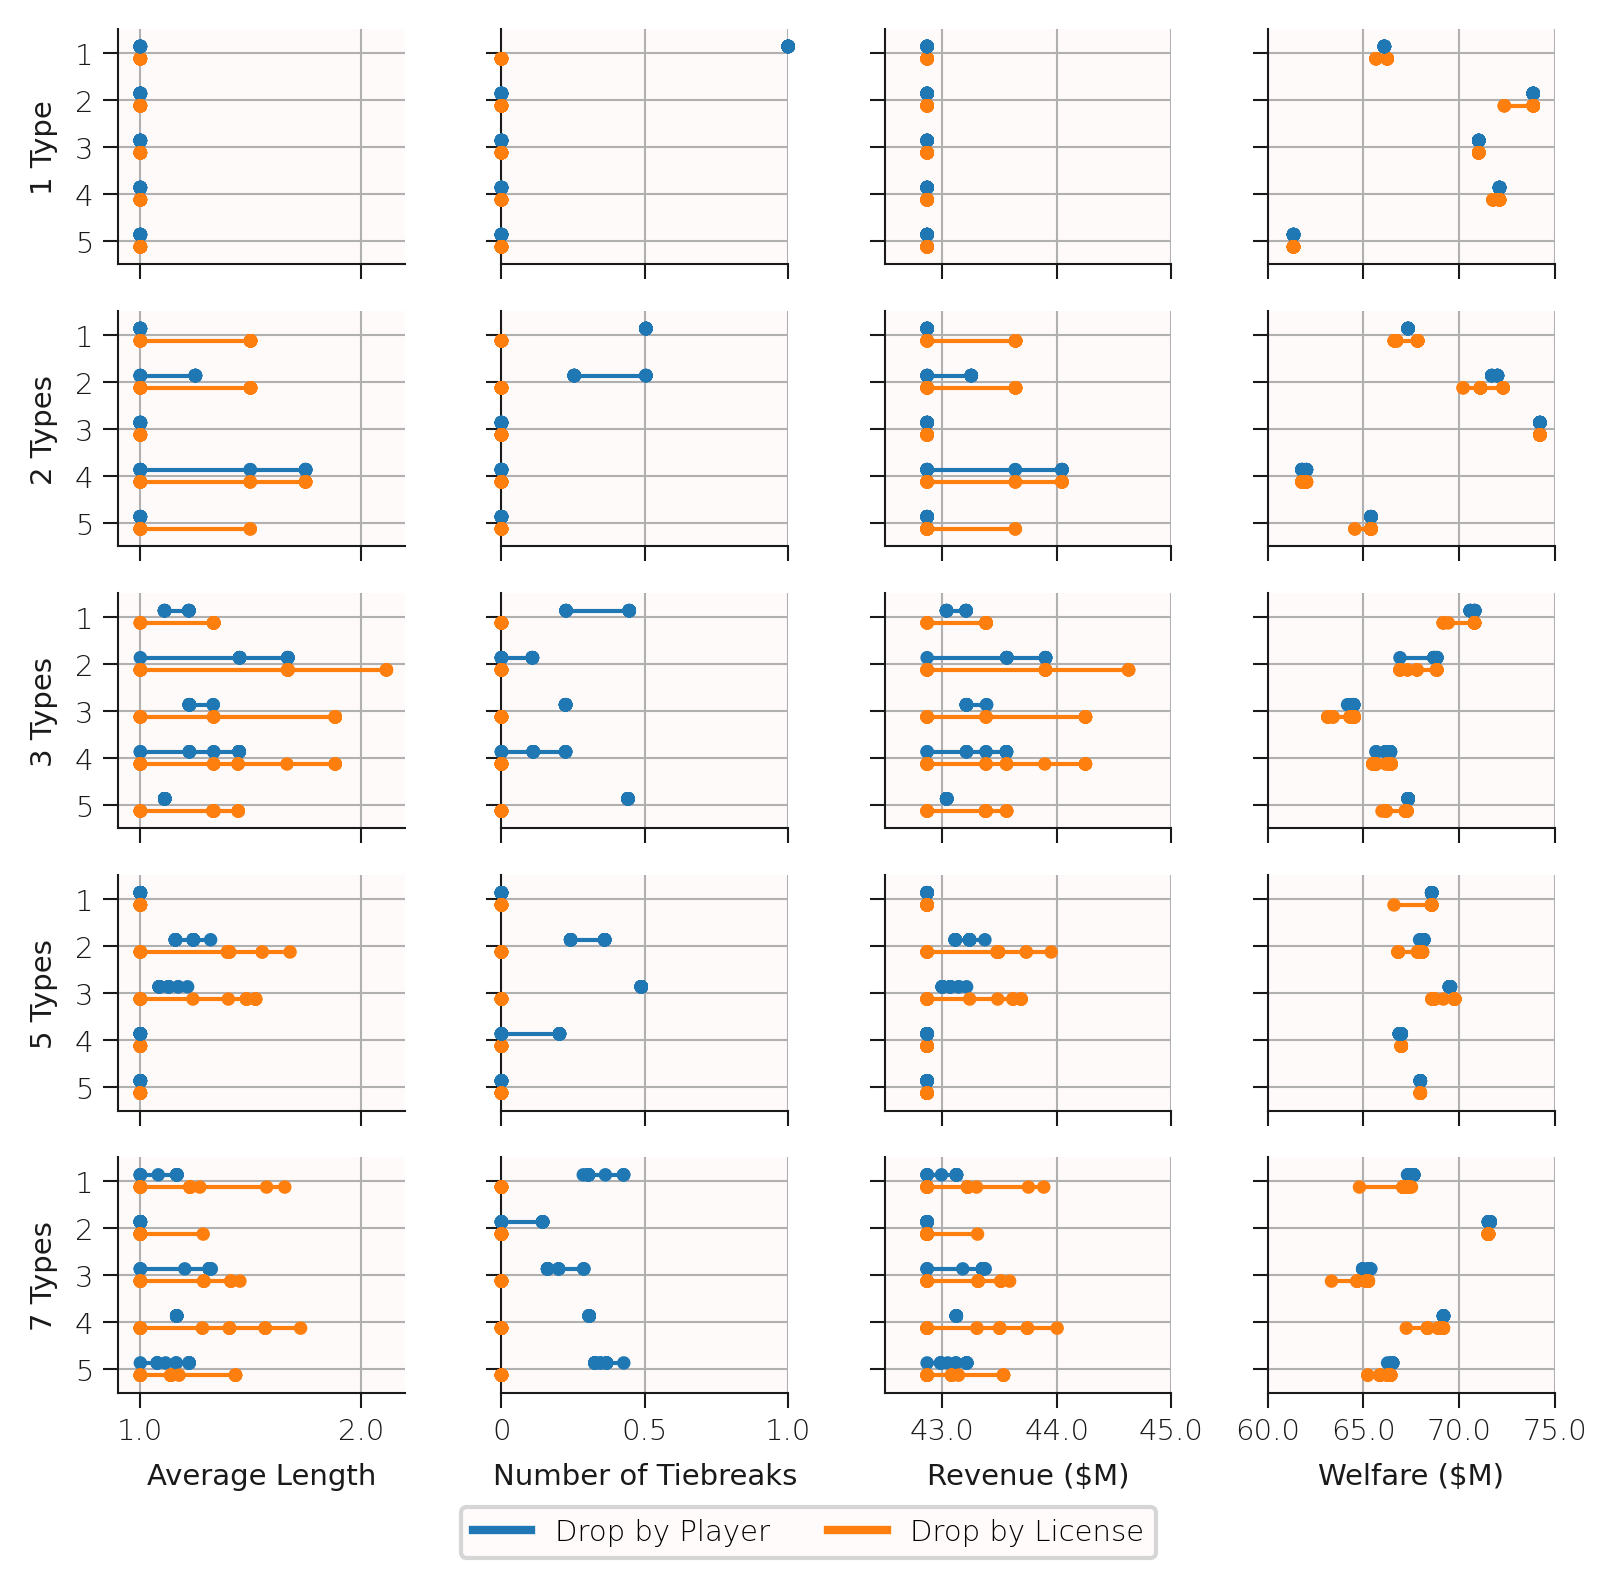

In [240]:
metrics = [
    'auction_lengths_no_prefix', 
    'num_lotteries', 
    # 'unsold_licenses', 
    'total_revenue', 
    'total_welfare'
]
axis_limits = {
    'auction_lengths_no_prefix': (0.9, 2.2),
    'num_lotteries': (0, 1),
    'unsold_licenses': (0, 1),
    'total_revenue': (42.5, 45.0),
    'total_welfare': (60.0, 75.0),
}
nash_conv_threshold = 0.1


df_cfr = pd.read_csv(f'{RESULTS_DIR}/feb10_2p_v1.csv').query('rho == 1')
df_cfr['auction_lengths_no_prefix'] = df_cfr.auction_lengths - 2
plot_metrics_by_game(df_cfr.query(f'nash_conv < {nash_conv_threshold}'), fname=f'feb10_2p_v1/cfr.png', metrics=metrics, axis_limits=axis_limits, figsize=(FIGURE_WIDTH, 5)); plt.show()

df_ppo = pd.read_csv(f'{RESULTS_DIR}/feb12_2p_ppo_v1.csv')
df_ppo['auction_lengths_no_prefix'] = df_ppo.auction_lengths - 2
plot_metrics_by_game(df_ppo.query(f'nash_conv < {nash_conv_threshold}'), fname=f'feb10_2p_v1/ppo.png', metrics=metrics, axis_limits=axis_limits, figsize=(FIGURE_WIDTH, 5)); plt.show()

df_combined = pd.concat([df_cfr, df_ppo])
plot_metrics_by_game(df_combined.query(f'nash_conv < {nash_conv_threshold}'), fname=f'feb10_2p_v1/combined.png', metrics=metrics, axis_limits=axis_limits, figsize=(FIGURE_WIDTH, 5)); plt.show()

In [246]:
print((df_combined.nash_conv > nash_conv_threshold).sum())
print((df_combined.nash_conv == 0).sum())

24
904


Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/straightforward_7types.png


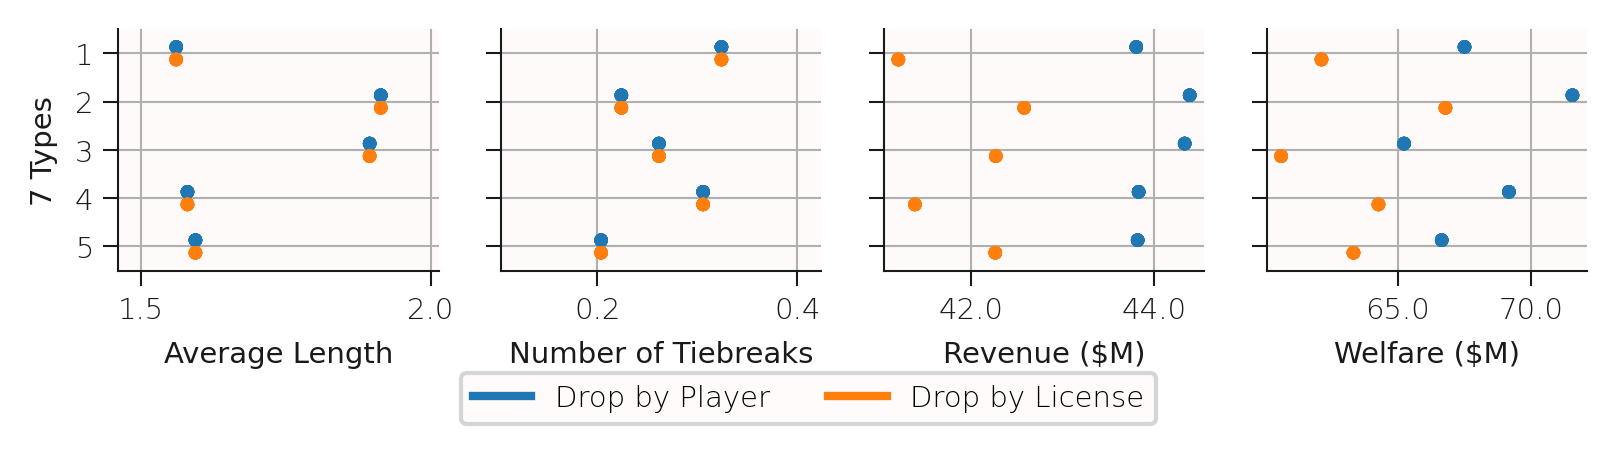

Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/straightforward.png


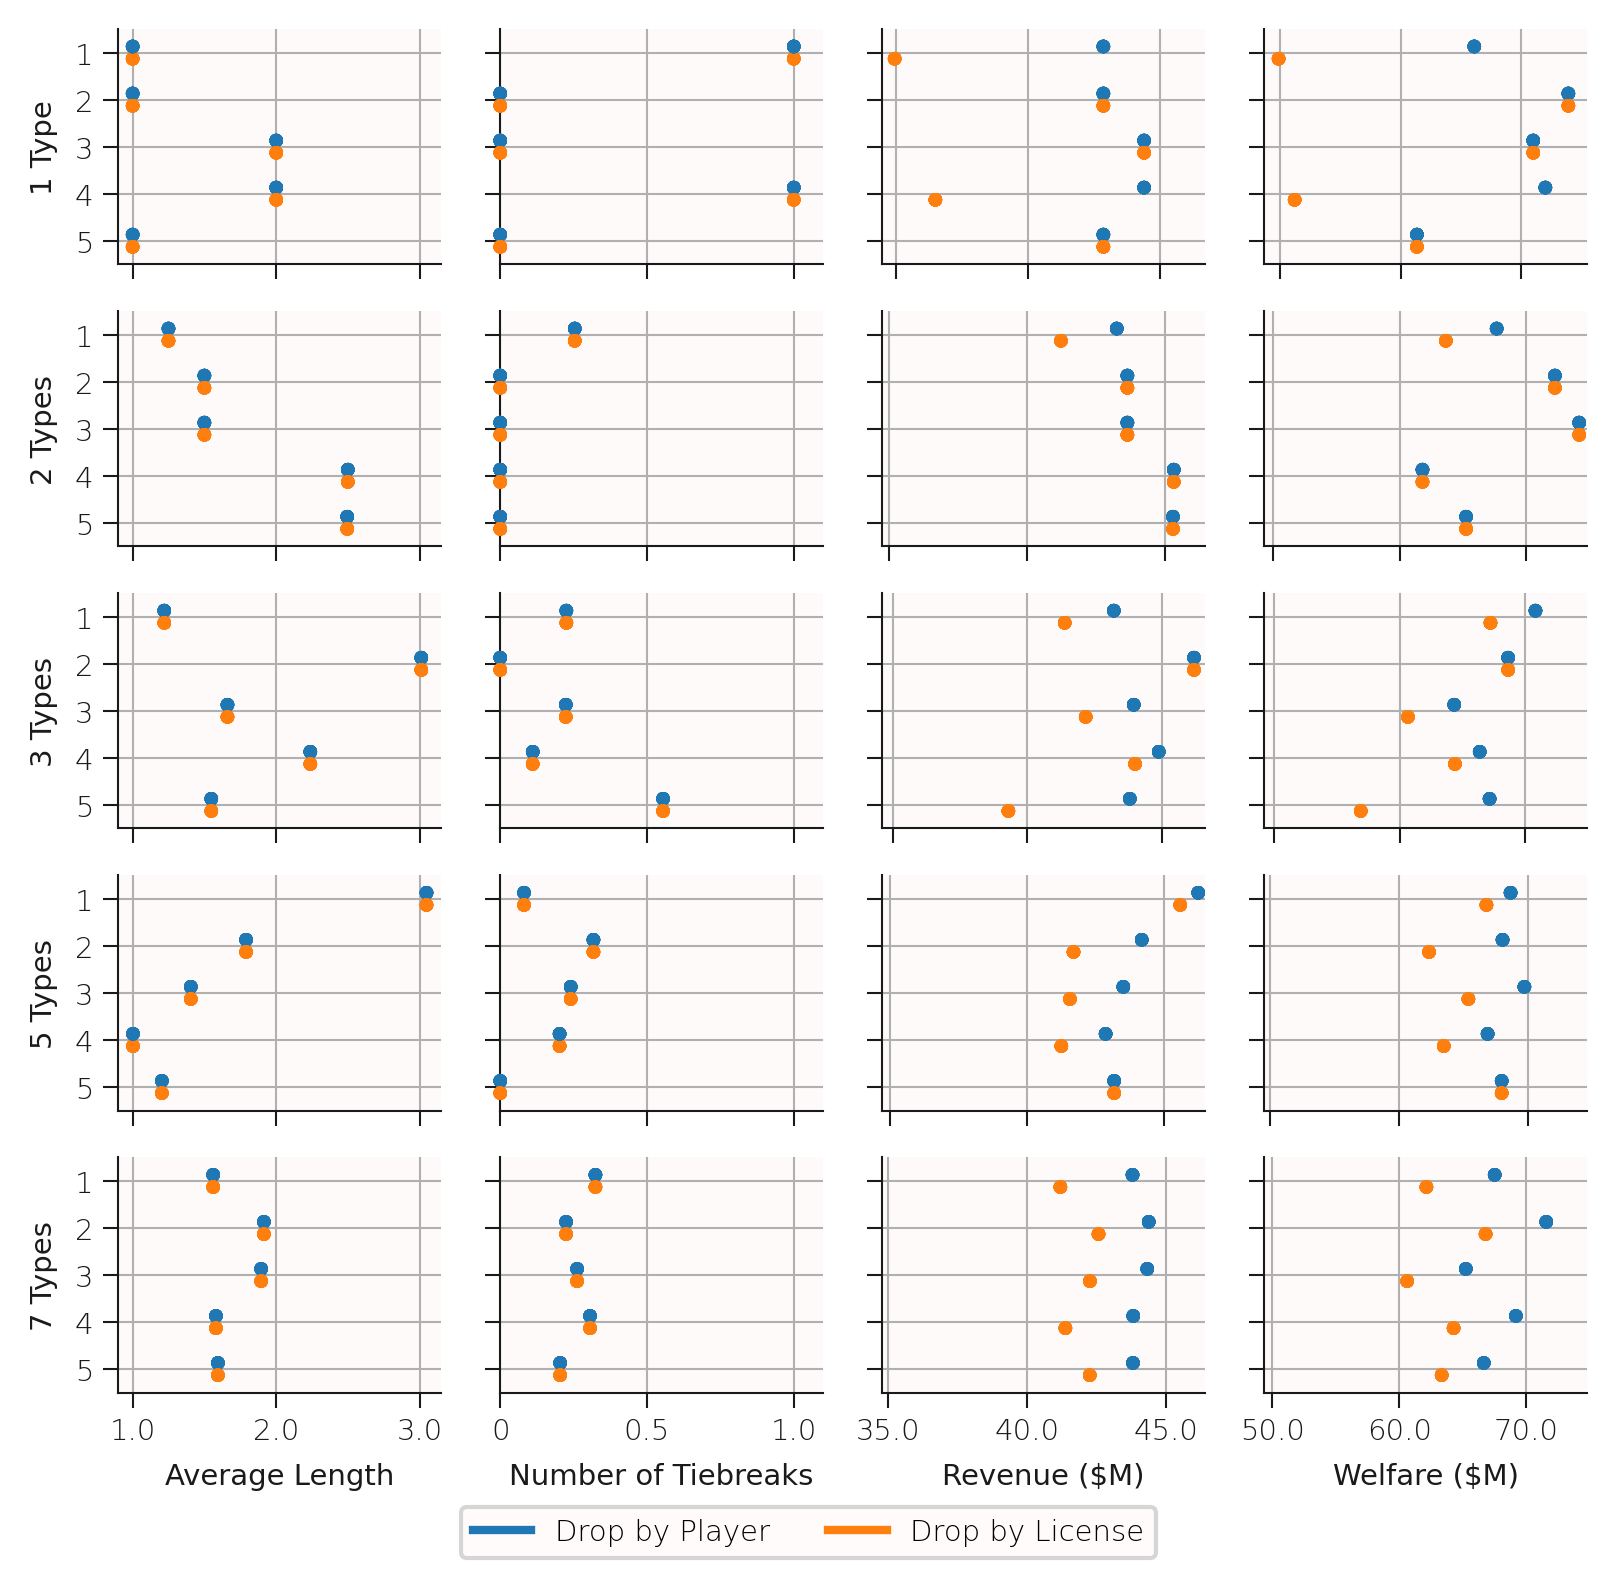

In [241]:
metrics = [
    'auction_lengths_no_prefix', 
    'num_lotteries', 
    # 'unsold_licenses', 
    'total_revenue', 
    'total_welfare'
]

df_cfr['straightforward_auction_lengths_no_prefix'] = df_cfr.straightforward_auction_lengths - 2

plot_metrics_by_game(df_cfr.query("n_types == 7"), fname=f'feb10_2p_v1/straightforward_7types.png', metrics=metrics, axis_limits='auto', figsize=(FIGURE_WIDTH, 1.4), straightforward=True); plt.show()

plot_metrics_by_game(df_cfr, fname=f'feb10_2p_v1/straightforward.png', metrics=metrics, axis_limits='auto', figsize=(FIGURE_WIDTH, 5), straightforward=True); plt.show()

In [257]:
df_cfr.rule.unique()

array(['tie_break', 'base'], dtype=object)

In [262]:
df_cfr.query('straightforward_nash_conv == 0')

,run_name,game_name,seed,config,alg,base_game_name,information_policy,activity_policy,undersell_policy,tiebreaking_policy,...,straightforward_common_allocations,straightforward_unsold,rho_0_nash_conv,rho_0_heuristic_conv,rho_0_nash_conv_runtime,rho_0_heuristic_conv_runtime,rho_0_nash_conv_player_improvements,rho_0_heuristic_conv_player_improvements,auction_lengths_no_prefix,straightforward_auction_lengths_no_prefix
24,feb10_2p_1type_feb10_2p_1type_1_base_dev1000_r...,feb10_2p_1type/feb10_2p_1type_1_base_dev1000_r...,100,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_1type_1,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((1, 1), 9992)]",[0. 0.],0.0,0.0,0.325923,0.150209,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
25,feb10_2p_1type_feb10_2p_1type_1_base_dev1000_r...,feb10_2p_1type/feb10_2p_1type_1_base_dev1000_r...,101,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_1type_1,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((1, 1), 9992)]",[0. 0.],0.0,0.0,0.324415,0.147711,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
26,feb10_2p_1type_feb10_2p_1type_1_base_dev1000_r...,feb10_2p_1type/feb10_2p_1type_1_base_dev1000_r...,103,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_1type_1,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((1, 1), 9992)]",[0. 0.],0.0,0.0,0.341079,0.148336,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
27,feb10_2p_1type_feb10_2p_1type_1_base_dev1000_r...,feb10_2p_1type/feb10_2p_1type_1_base_dev1000_r...,102,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_1type_1,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((1, 1), 9992)]",[0. 0.],0.0,0.0,0.324821,0.148737,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
28,feb10_2p_1type_feb10_2p_1type_1_base_dev1000_r...,feb10_2p_1type/feb10_2p_1type_1_base_dev1000_r...,102,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_1type_1,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_LICENSE,...,"[((1, 1), 9992)]",[0. 0.],0.0,0.0,0.446686,0.185805,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,feb10_2p_5type_feb10_2p_5type_3_base_dev1000_r...,feb10_2p_5type/feb10_2p_5type_3_base_dev1000_r...,105,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_5type_3,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((0, 3), 8968), ((1, 1), 1024)]",[0.00000000e+00 2.22044605e-16],0.0,0.0,5.074344,2.905988,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
386,feb10_2p_5type_feb10_2p_5type_3_base_dev1000_r...,feb10_2p_5type/feb10_2p_5type_3_base_dev1000_r...,106,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_5type_3,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((0, 3), 8968), ((1, 1), 1024)]",[0.00000000e+00 2.22044605e-16],0.0,0.0,4.641068,2.716413,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
387,feb10_2p_5type_feb10_2p_5type_3_base_dev1000_r...,feb10_2p_5type/feb10_2p_5type_3_base_dev1000_r...,107,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_5type_3,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((0, 3), 8968), ((1, 1), 1024)]",[0.00000000e+00 2.22044605e-16],0.0,0.0,5.003150,2.854341,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0
388,feb10_2p_5type_feb10_2p_5type_3_base_dev1000_r...,feb10_2p_5type/feb10_2p_5type_3_base_dev1000_r...,108,cfr_10external_plus_linear,cfr_external_linear,feb10_2p_5type_3,SHOW_DEMAND,ON,UNDERSELL,DROP_BY_PLAYER,...,"[((0, 3), 8968), ((1, 1), 1024)]",[0.00000000e+00 2.22044605e-16],0.0,0.0,4.945826,2.824901,"[0.0, 0.0]","[0.0, 0.0]",1.0,1.0


In [267]:
print(df_cfr.query('n_types == 7').straightforward_nash_conv.describe())
print((df_cfr.query('n_types == 7').straightforward_nash_conv > 1).mean())

count    100.000000
mean       1.244227
std        1.021797
min        0.179026
25%        0.301825
50%        0.765625
75%        2.245026
max        3.103105
Name: straightforward_nash_conv, dtype: float64
0.4


In [217]:
df_ppo.nash_conv.quantile(np.linspace(0, 1, 41))

0.000    0.000000
0.025    0.000000
0.050    0.000000
0.075    0.000000
0.100    0.000000
0.125    0.000000
0.150    0.000000
0.175    0.000000
0.200    0.000000
0.225    0.000000
0.250    0.000000
0.275    0.000000
0.300    0.000000
0.325    0.000000
0.350    0.000000
0.375    0.000000
0.400    0.000000
0.425    0.000000
0.450    0.000000
0.475    0.000000
0.500    0.000000
0.525    0.000000
0.550    0.000000
0.575    0.000000
0.600    0.000000
0.625    0.000000
0.650    0.000000
0.675    0.000000
0.700    0.000000
0.725    0.000000
0.750    0.000000
0.775    0.000000
0.800    0.000000
0.825    0.000000
0.850    0.000686
0.875    0.014147
0.900    0.044667
0.925    0.051529
0.950    0.086129
0.975    0.142771
1.000    0.413786
Name: nash_conv, dtype: float64

['cfr_10external_plus_linear' 'cfr_10_no_tremexternal_plus_linear_no_trem']
cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/1.png


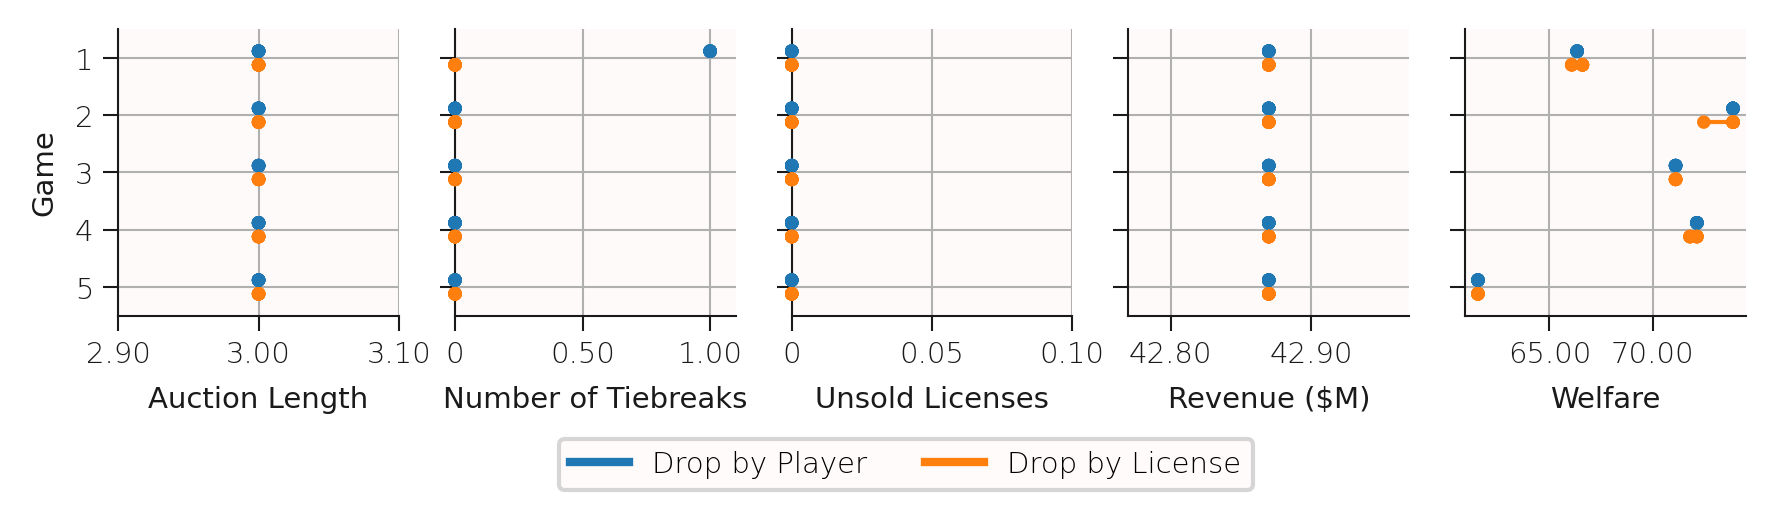

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/2.png


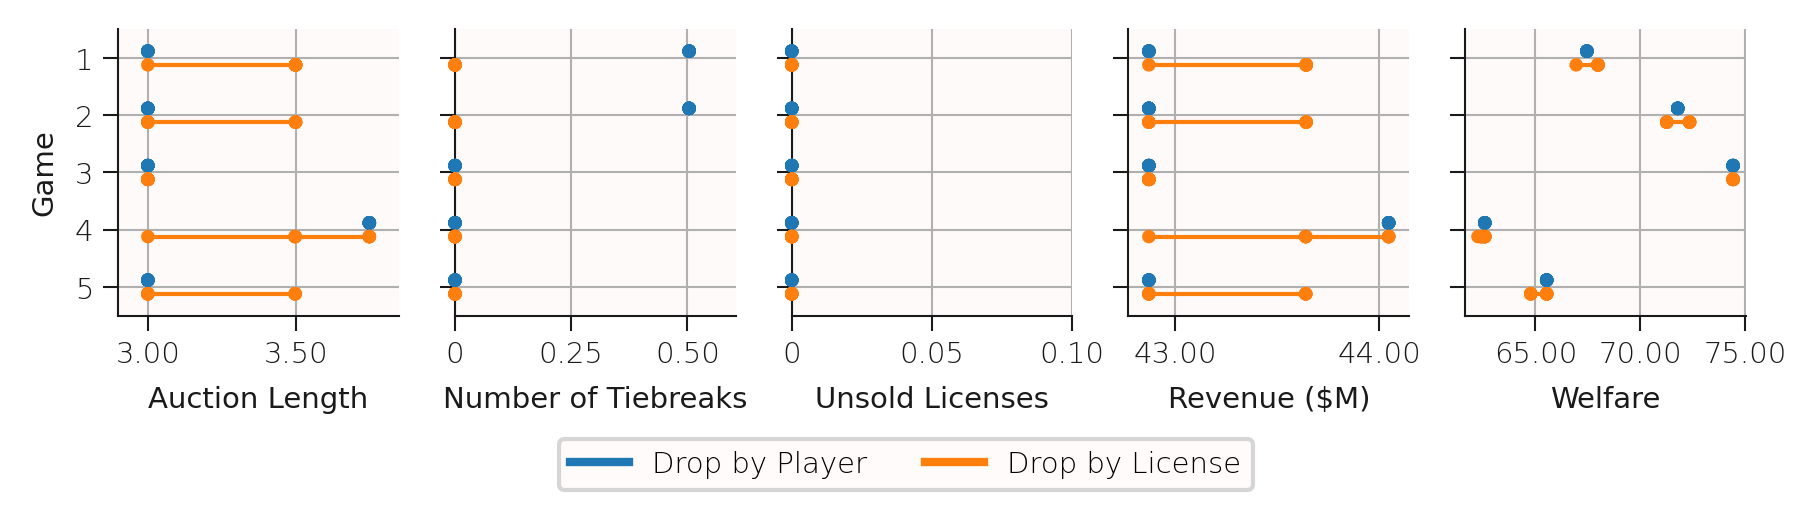

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.003412
std        0.025539
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.231958
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/3.png


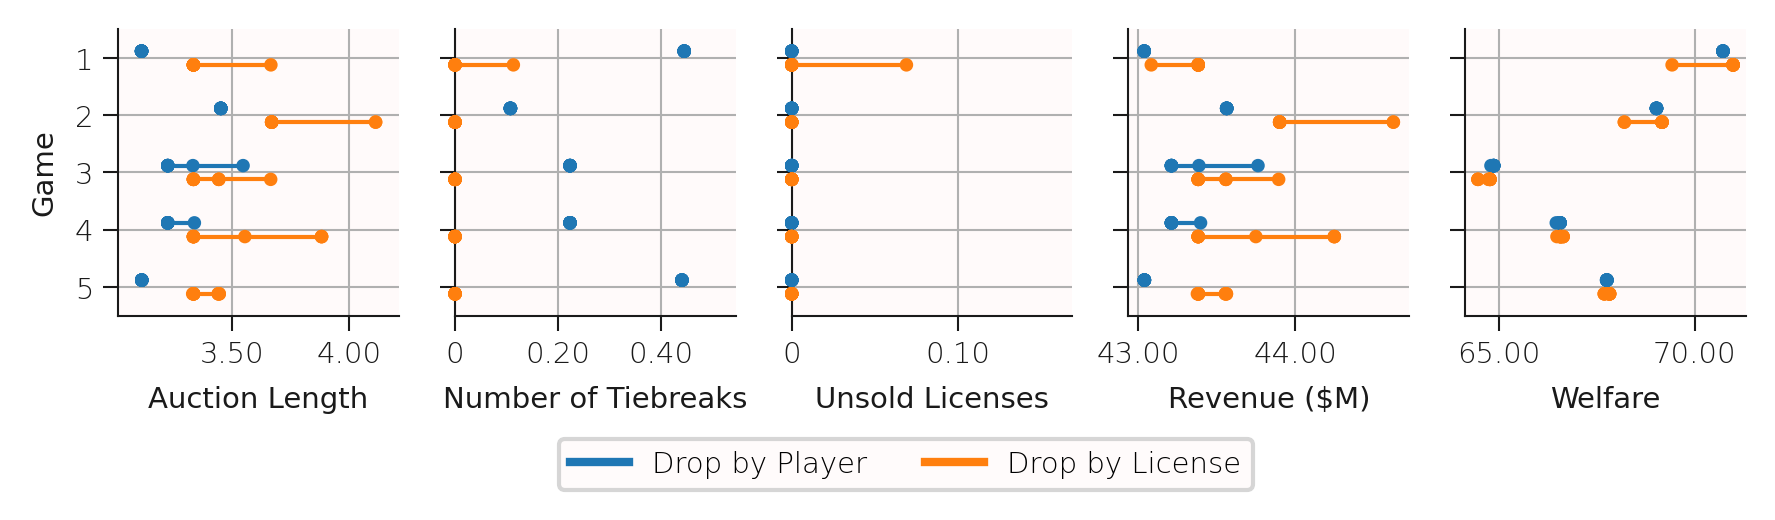

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.000113
std        0.001125
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.011253
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.000000
mean       0.000113
std        0.001125
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.011253
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/5.png


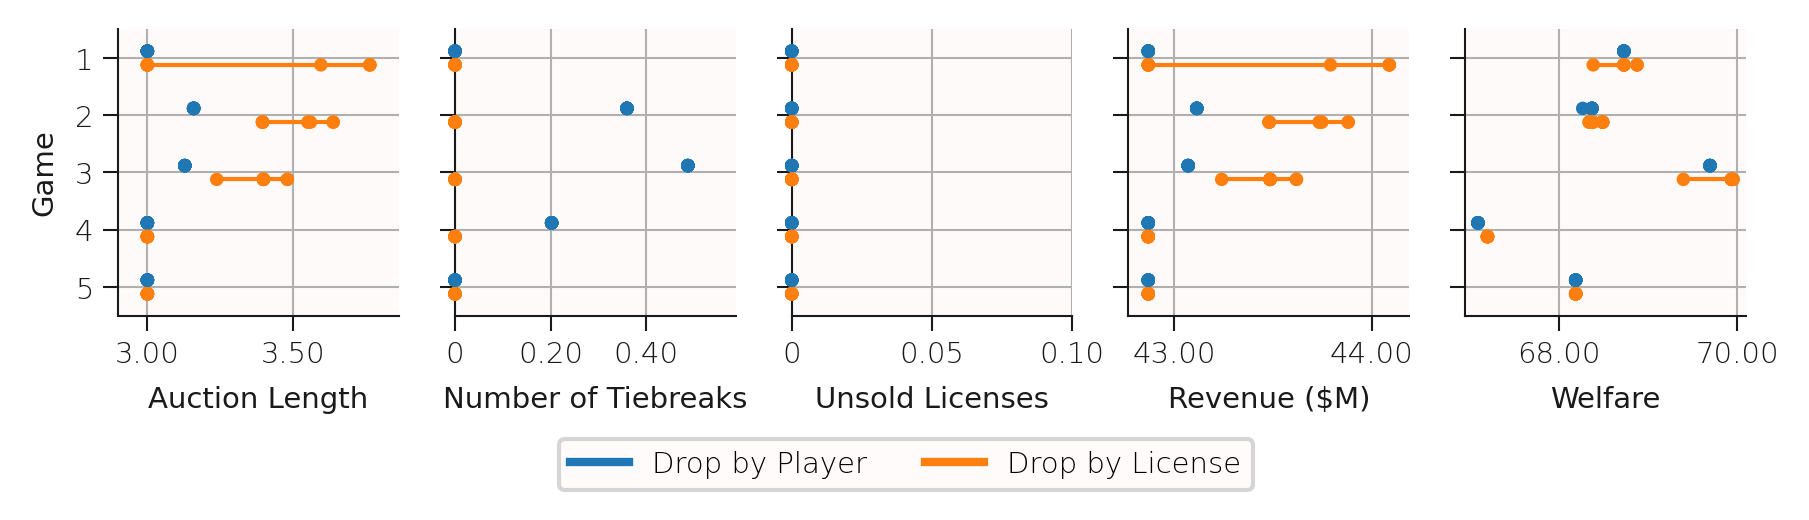

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.002626
std        0.013110
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.088403
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.000000
mean       0.000093
std        0.000626
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.005787
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/7.png


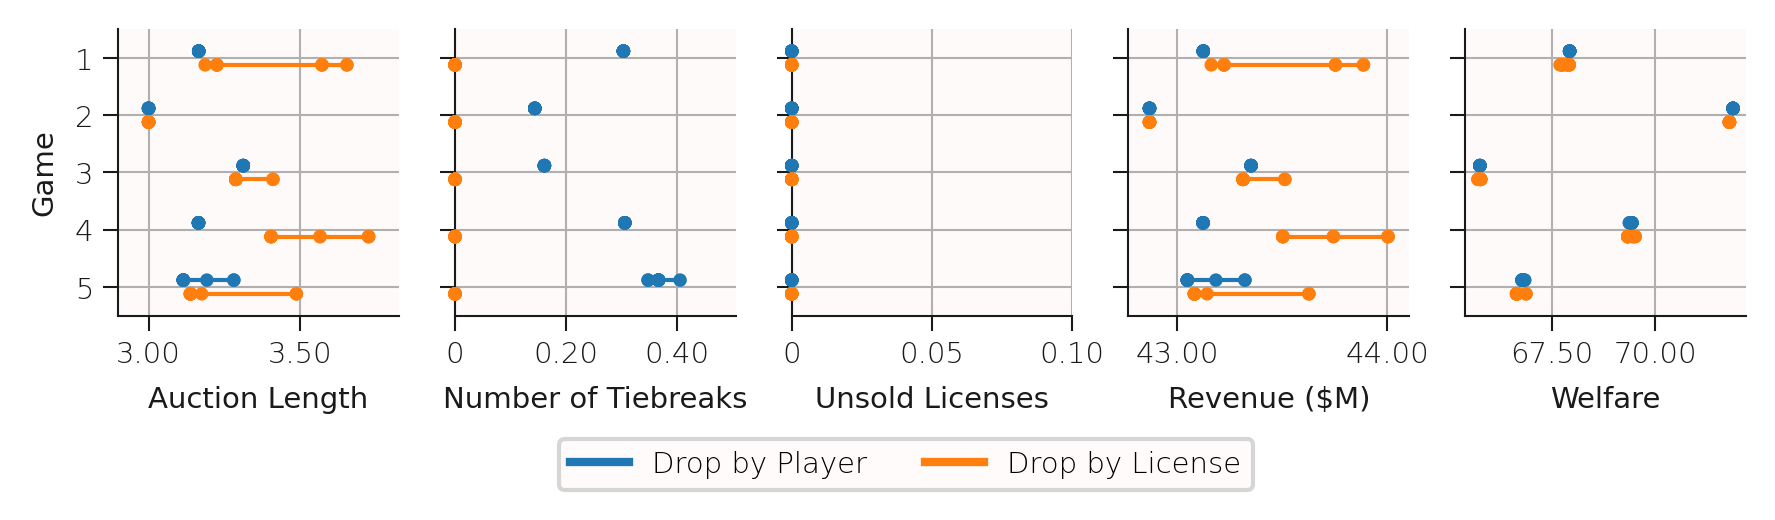

In [83]:
df = pd.read_csv(f'{RESULTS_DIR}/feb10_2p_v1.csv')

print(df.config.unique())

# cfg = 'cfr_10external_plus_linear'
cfg = 'cfr_10_no_tremexternal_plus_linear_no_trem'
for n_types in [1, 2, 3, 5, 7]:
    df_cfg = df.query(f"config == '{cfg}' and n_types == {n_types}")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb10_2p_v1/{n_types}.png'); plt.show()

# feb8_3p_5supply_v2

['cfr_10_no_tremexternal_plus_linear_no_trem' 'cfr_10external_plus_linear']
cfr_10external_plus_linear
Uncomputable NashConvs: 100.0%
Distribution of computed NashConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v2/cfr_10external_plus_linear.png


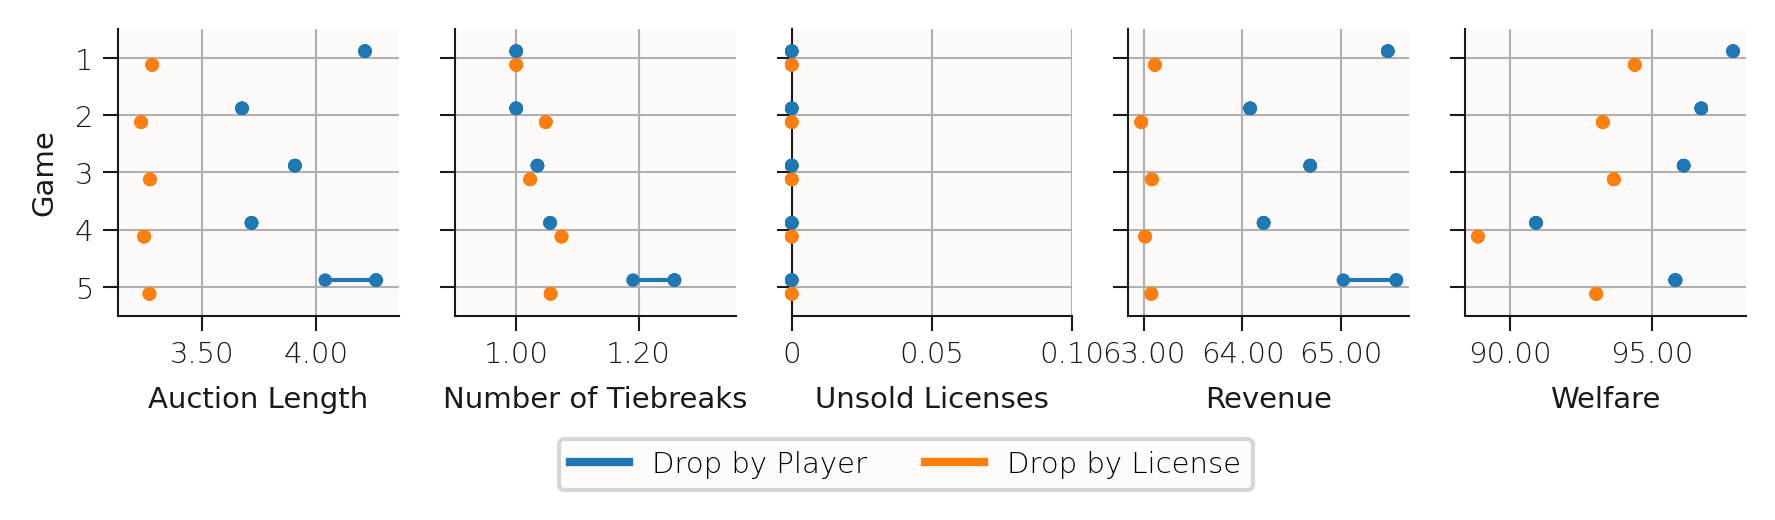

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 92.0%
Distribution of computed NashConvs:
count    4.000000
mean     0.005369
std      0.000679
min      0.004781
25%      0.004781
50%      0.005369
75%      0.005957
max      0.005957
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    6.000000
mean     0.001594
std      0.002469
min      0.000000
25%      0.000000
50%      0.000000
75%      0.003586
max      0.004781
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v2/cfr_10_no_tremexternal_plus_linear_no_trem.png


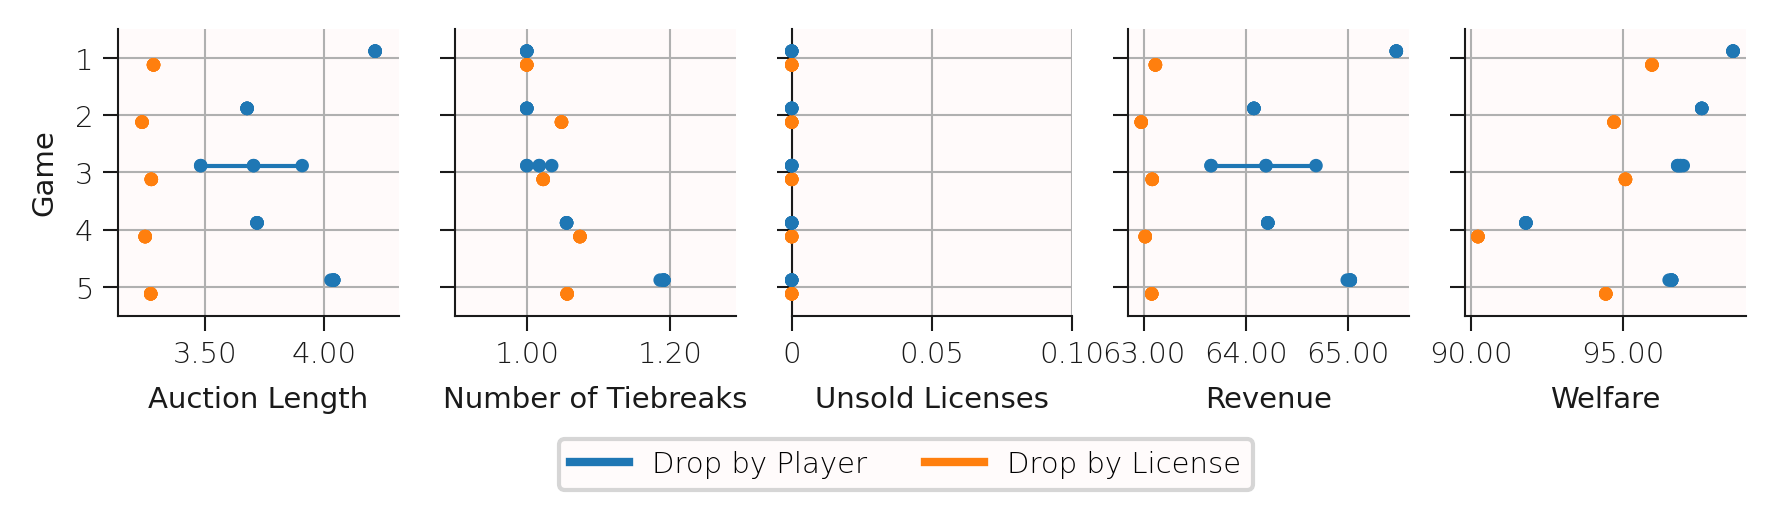

In [39]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_5supply_v2.csv')

print(df.config.unique())

for cfg in ['cfr_10external_plus_linear', 'cfr_10_no_tremexternal_plus_linear_no_trem']:
    df_cfg = df.query(f"config == '{cfg}'")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_5supply_v2/{cfg}.png'); plt.show()

# feb8_3p_5supply_v1
3 players, 5 encumbered licenses

cfr_10external_plus_linear
Uncomputable NashConvs: 98.0%
Distribution of computed NashConvs:
count    1.000000
mean     0.000478
std           NaN
min      0.000478
25%      0.000478
50%      0.000478
75%      0.000478
max      0.000478
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    2.000000
mean     0.001930
std      0.002053
min      0.000478
25%      0.001204
50%      0.001930
75%      0.002656
max      0.003382
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v1/cfr_10external_plus_linear.png


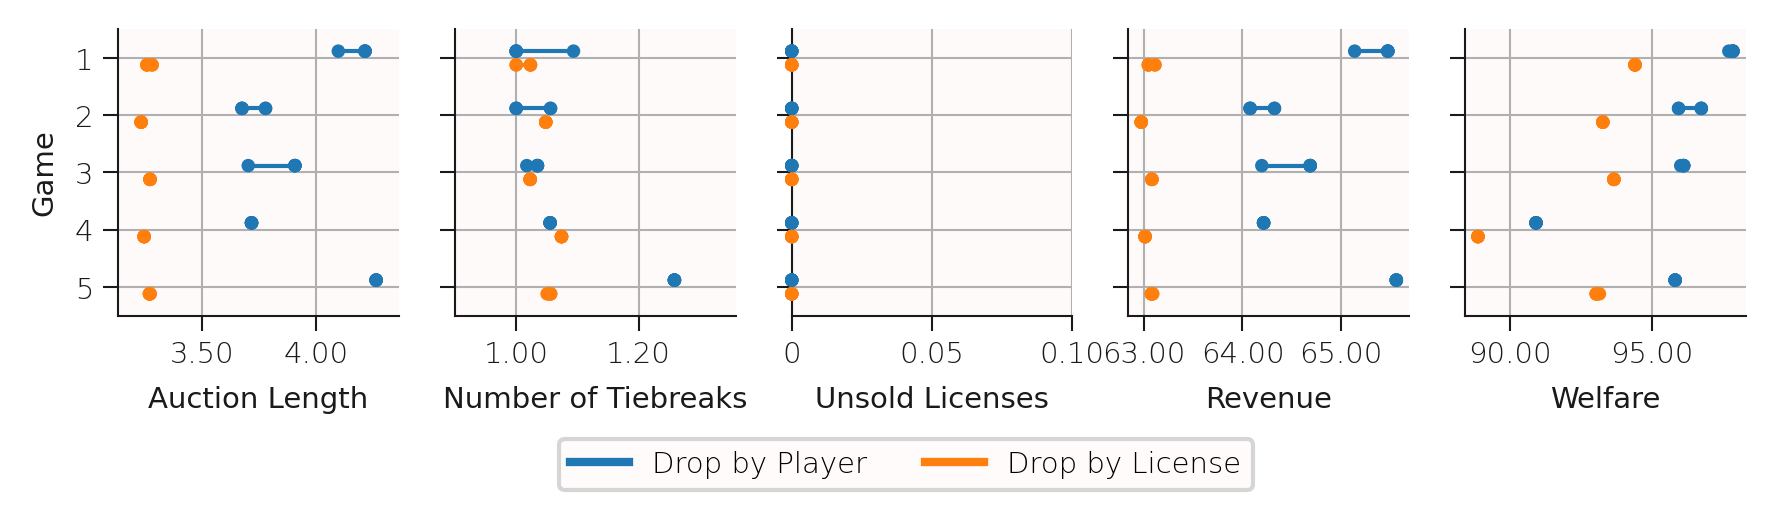

ppo_jun8_23ppo_76
Uncomputable NashConvs: 100.0%
Distribution of computed NashConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    1.000000
mean     0.021356
std           NaN
min      0.021356
25%      0.021356
50%      0.021356
75%      0.021356
max      0.021356
Name: heuristic_conv, dtype: float64


ValueError: Axis limits cannot be NaN or Inf

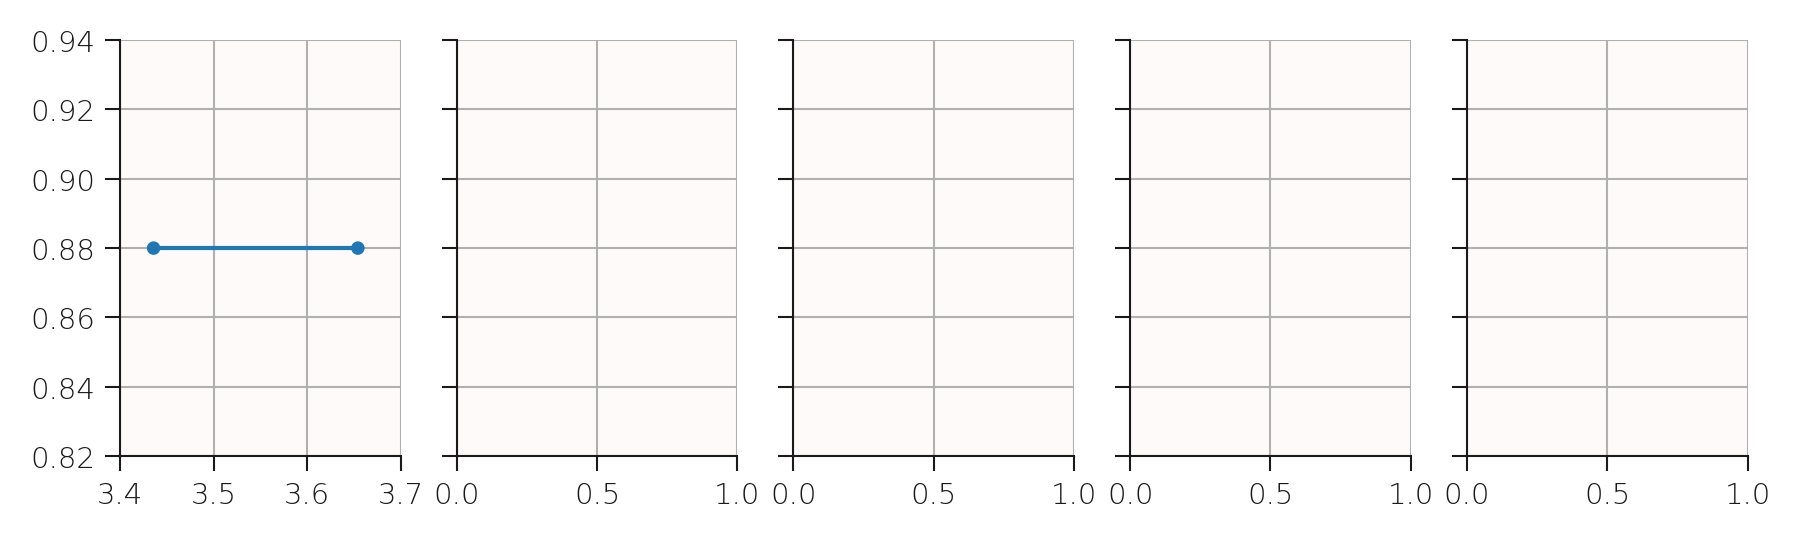

In [34]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_5supply_v1.csv')

for cfg in ['cfr_10external_plus_linear', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 1")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_5supply_v1/{cfg}.png'); plt.show()

# feb8_3p_7supply_v2
3 players, 7 encumbered licenses

cfr_10external_plus_linear
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    50.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_7supply_v2/cfr_10external_plus_linear.png


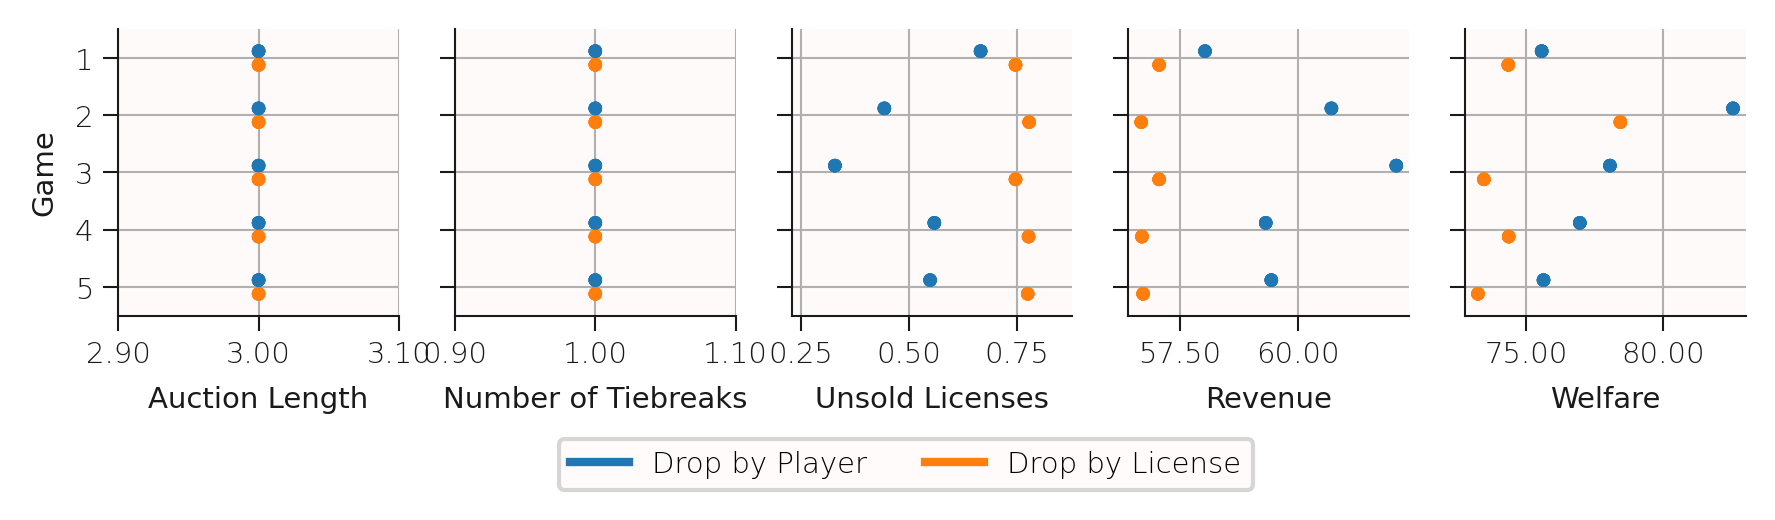

ppo_jun8_23ppo_76
Uncomputable NashConvs: 26.0%
Distribution of computed NashConvs:
count    37.000000
mean      0.065319
std       0.085062
min       0.000000
25%       0.010195
50%       0.026719
75%       0.067375
max       0.285998
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_7supply_v2/ppo_jun8_23ppo_76.png


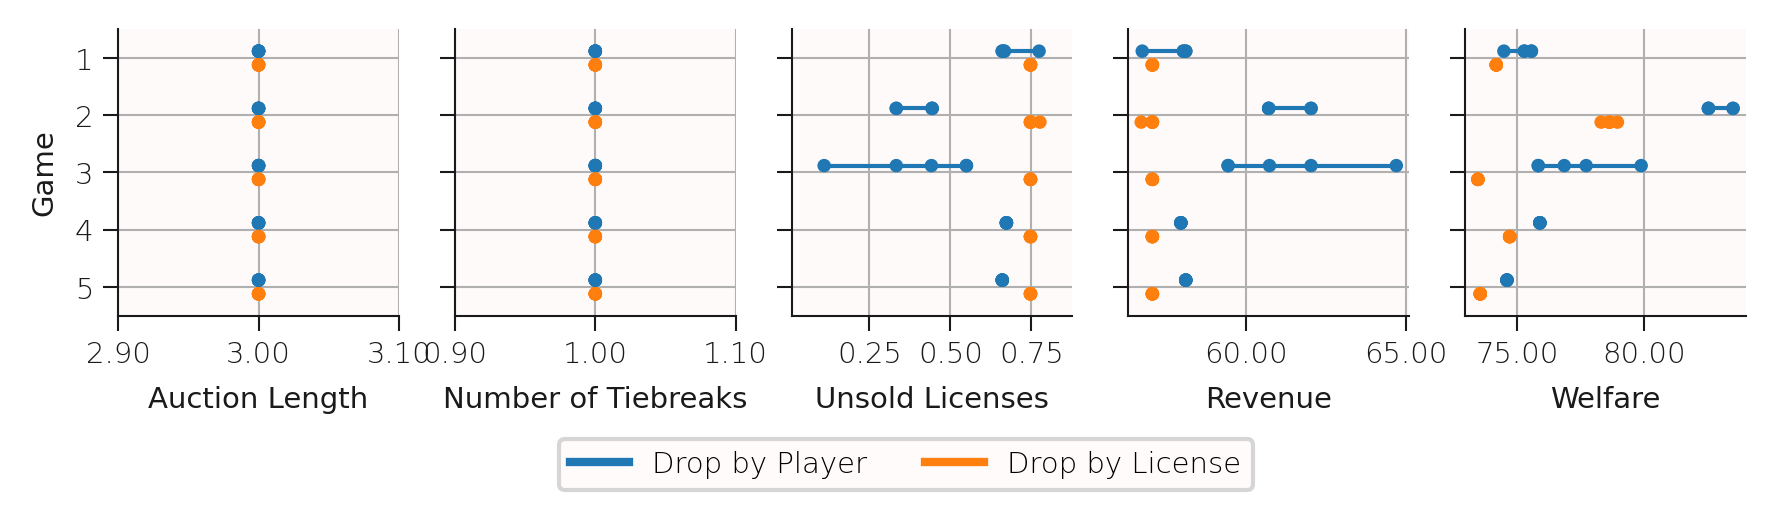

In [32]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_7supply_v2.csv')

for cfg in ['cfr_10external_plus_linear', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 1")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_7supply_v2/{cfg}.png'); plt.show()

# feb8_v1

cfr_port_10_extexternal_plus_linear
Uncomputable NashConvs: 27.3%
Distribution of computed NashConvs:
count    80.000000
mean      0.009921
std       0.061899
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.426840
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/cfr_port_10_extexternal_plus_linear.png


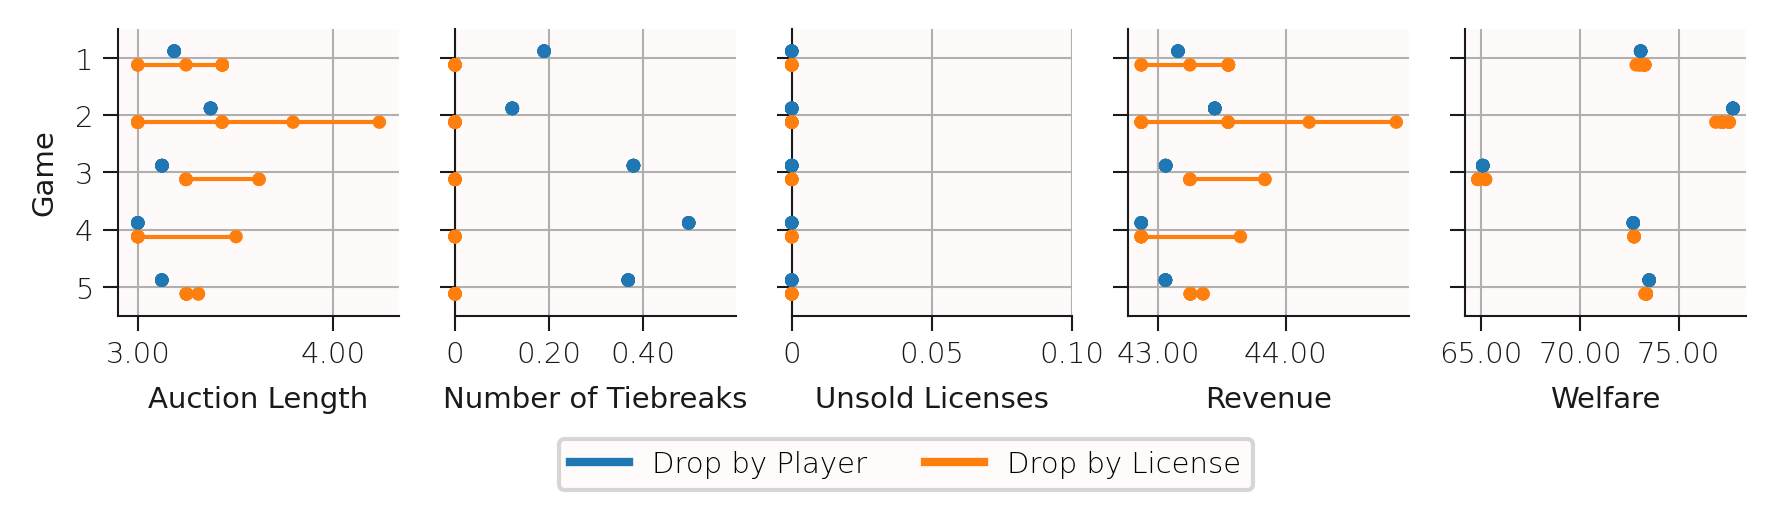

cfr_port_10_extexternal_plus_linear_no_trem
Uncomputable NashConvs: 18.2%
Distribution of computed NashConvs:
count    90.000000
mean      0.000214
std       0.000646
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.002140
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/cfr_port_10_extexternal_plus_linear_no_trem.png


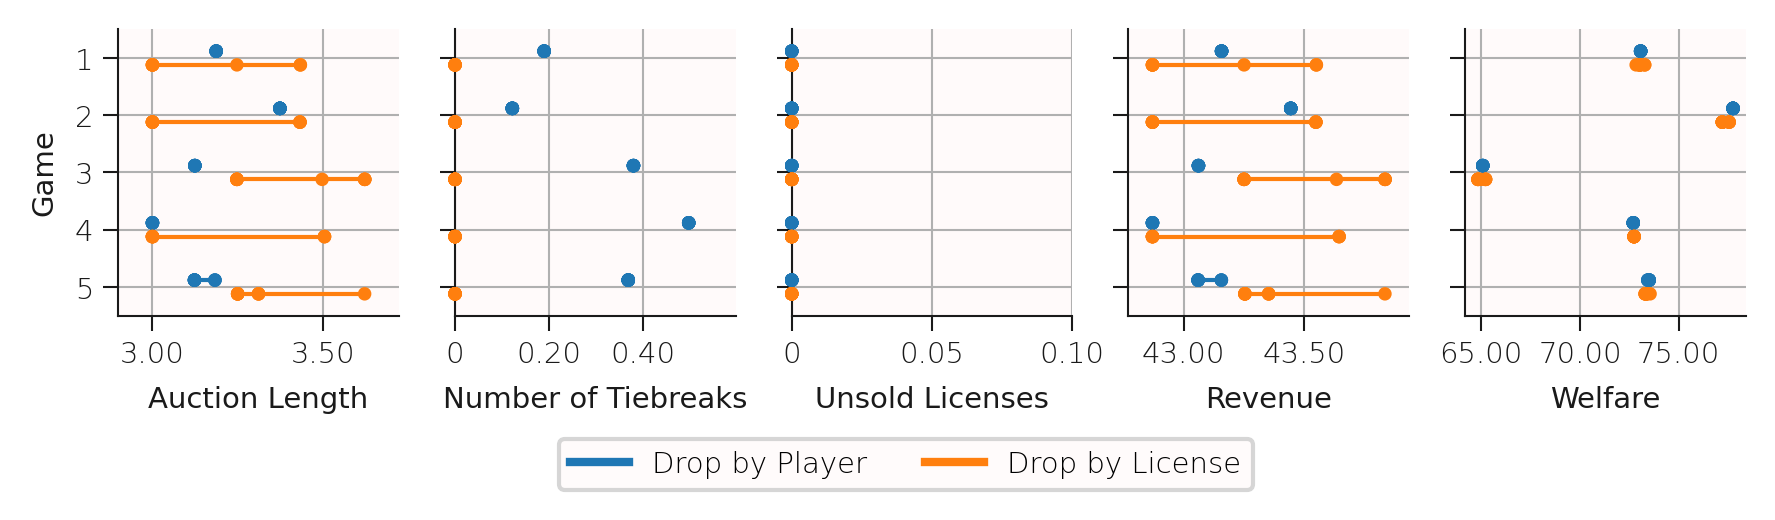

ppo_jun8_23ppo_76
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    110.000000
mean       0.299507
std        1.103819
min        0.000000
25%        0.000000
50%        0.000000
75%        0.179375
max       10.699844
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/ppo_jun8_23ppo_76.png


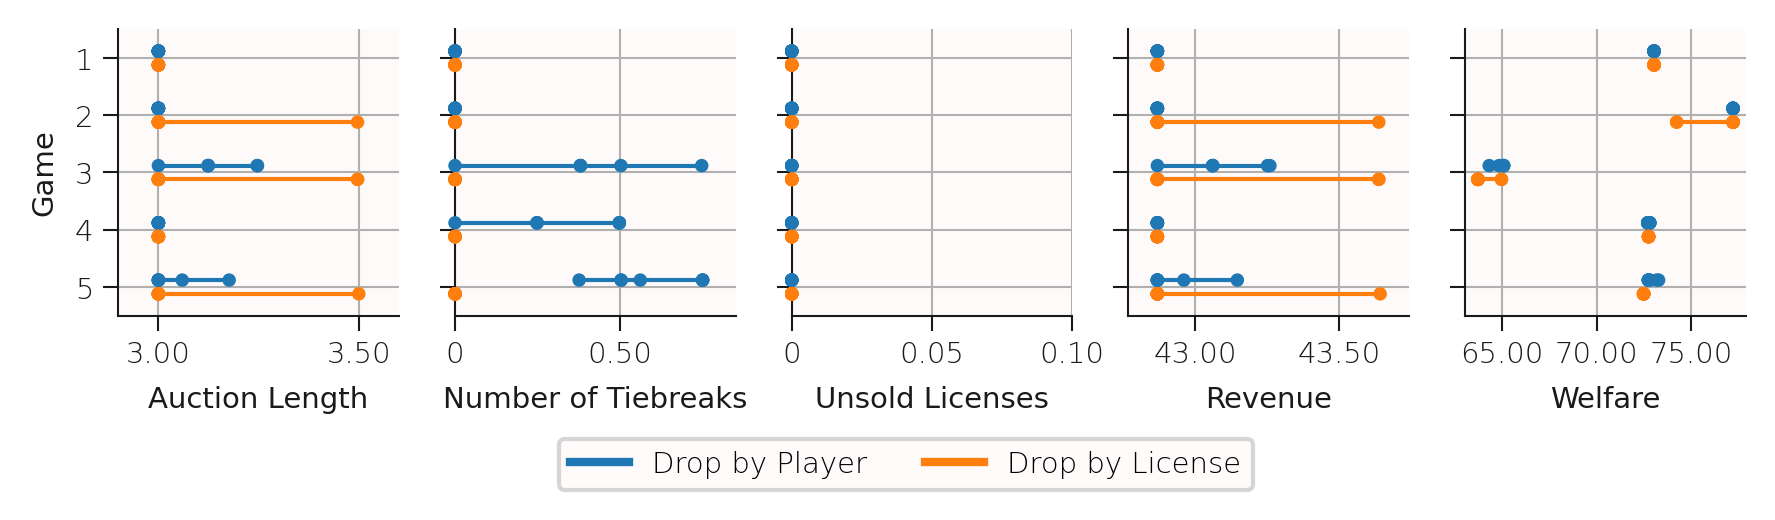

In [35]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_v1.csv')

for cfg in ['cfr_port_10_extexternal_plus_linear', 'cfr_port_10_extexternal_plus_linear_no_trem', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 0")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg_low_nashconv, fname=f'feb8_v1/{cfg}.png'); plt.show()

# feb6_v2

In [14]:
df = pd.read_csv(f'{RESULTS_DIR}/feb6_v2.csv')

In [21]:
for rho in [1, 0]:
    plot_metrics_by_game(df.query(f'rho == {rho}'), fname=f'feb6_v2/rho{rho}.png'); plt.show()
    plot_metrics_by_game(df.query(f'rho == {rho} and nash_conv < 0.05'), fname=f'feb6_v2/rho{rho}_low_nashconv.png'); plt.show()

In [10]:
(df.nash_conv < 0.2).mean()

0.7727272727272727